# Introduction

Author: Harneet Rishi

Purpose: Perform time-series analysis comparing promoter and gene knockdowns (Supp Fig 12)

# Imports

## Modules/packages

In [61]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.path import Path
import matplotlib.patches as patches
import seaborn as sns

from scipy.stats import mannwhitneyu

import warnings
warnings.filterwarnings('ignore')

## Data

### sgRNA annotations

In [2]:
df_sgRNA_info_update_3 = pd.read_csv('SourceData/APAHR007_v4_21-df_sgRNA_info_update_3.csv')
df_sgRNA_info_update_3.drop(labels = 'seq.1', inplace = True, axis = 1)
df_sgRNA_info_update_3.set_index(keys = 'seq', inplace = True, drop = False)
df_sgRNA_info_update_3.head()

,seq,pos,strand,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
seq,,,,,,,,
agcggtaaaattcgtgtaat,agcggtaaaattcgtgtaat,923423,+,Promoter,,NaN,NaN,0
gcgagaaaccttattaacca,gcgagaaaccttattaacca,100609,+,Promoter,,NaN,NaN,0
ggcgtgccgatgggctacgg,ggcgtgccgatgggctacgg,3046225,-,Promoter,,NaN,NaN,0
gggctacggtggcccacacg,gggctacggtggcccacacg,3046214,-,Promoter,,NaN,NaN,0
agttgtatgatgcaactagt,agttgtatgatgcaactagt,4638701,-,Promoter,,NaN,NaN,0


In [3]:
df_sgRNA_info_update_3_IndGeneName = df_sgRNA_info_update_3.set_index(keys = 'gene_name_F2', drop = False)
df_sgRNA_info_update_3_IndGeneName = df_sgRNA_info_update_3_IndGeneName.drop_duplicates(subset = 'gene_name_F2')

### Gene annotations

In [6]:
df_genomeInfo = pd.read_table('Annotations/genomeInfo.cgi.txt')
df_genomeInfo_dropdup = df_genomeInfo.drop_duplicates(['name'])
df_genomeInfo_dropdup.set_index(keys = 'sysName', inplace = True, drop = False)
df_genomeInfo_dropdup

,locusId,accession,GI,scaffoldId,start,stop,strand,sysName,name,desc,COG,COGFun,COGDesc,TIGRFam,TIGRRoles,GO,EC,ECDesc
sysName,,,,,,,,,,,,,,,,,,
b0001,14146,NP_414542.1,16127995.0,7023,190,255,+,b0001,thrL,thr operon leader peptide (NCBI),NaN,NaN,NaN,TIGR02077 thr operon leader peptide [thrL],Amino acid biosynthesis:Aspartate family,GO:0009088,NaN,NaN
b0002,14147,NP_414543.1,16127996.0,7023,337,2799,+,b0002,thrA,bifunctional aspartokinase I/homeserine dehydr...,COG527,E,Aspartokinases,TIGR00657 aspartate kinase,Amino acid biosynthesis:Aspartate family,"GO:0009067,GO:0016597,GO:0004072,GO:0004412",2.7.2.4,Aspartate kinase.
b0003,14148,NP_414544.1,16127997.0,7023,2801,3733,+,b0003,thrB,homoserine kinase (NCBI),COG83,E,Homoserine kinase,TIGR00191 homoserine kinase [thrB],Amino acid biosynthesis:Aspartate family,"GO:0006566,GO:0016310,GO:0004413,GO:0005524",2.7.1.39,Homoserine kinase.
b0004,14149,NP_414545.1,16127998.0,7023,3734,5020,+,b0004,thrC,threonine synthase (NCBI),COG498,E,Threonine synthase,TIGR00260 threonine synthase [thrC],Amino acid biosynthesis:Aspartate family,"GO:0009088,GO:0030170,GO:0004795",4.2.3.1,Threonine synthase.
b0005,14150,NP_414546.1,16127999.0,7023,5234,5530,+,b0005,yaaX,hypothetical protein (NCBI),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4399,18420,NP_418816.1,16132216.0,7023,4634719,4636143,+,b4399,creC,sensory histidine kinase in two-component regu...,COG642,T,Signal transduction histidine kinase,NaN,NaN,"GO:0007165,GO:0018106,GO:0016020,GO:0000155,GO...","2.7.13.3,2.7.3.-","Histidine kinase.,"
b4400,18421,NP_418817.1,16132217.0,7023,4636201,4637553,+,b4400,creD,inner membrane protein (NCBI),COG4452,V,Inner membrane protein involved in colicin E2 ...,NaN,NaN,NaN,NaN,NaN
b4401,18422,NP_418818.1,16132218.0,7023,4638329,4637613,-,b4401,arcA,DNA-binding response regulator in two-componen...,COG745,TK,Response regulators consisting of a CheY-like ...,NaN,NaN,"GO:0006355,GO:0000160,GO:0003677,GO:0000156",NaN,NaN


In [7]:
NoEffect_genes = ['acpS', 'asd', 'can', 'cca', 'efp', 'erpA', 'folK', 'glmS', 'groL',
       'grpE', 'hemG', 'ribB', 'ubiA', 'yabQ', 'yceQ', 'yqgD', 'yqgF']  # remove essential genes that didn't show an effect (knockdown)

### Fitness values

In [8]:
df_sgRNA_counts_LR_withcounts_info = pd.read_csv('SourceData/APAHR021_3-df_sgRNA_counts_LR_withcounts_info.csv')
df_sgRNA_counts_LR_withcounts_info.drop(labels = 'seq.1', axis = 1, inplace = True)
df_sgRNA_counts_LR_withcounts_info.set_index(keys=  'seq', inplace = True, drop = False)
df_sgRNA_counts_LR_withcounts_info.drop(labels = ['gene_name'], inplace = True, axis = 1)
df_sgRNA_counts_LR_withcounts_info['gene_name_F2'] = df_sgRNA_info_update_3['gene_name_F2']
df_sgRNA_counts_LR_withcounts_info['bnumber_F2'] = df_sgRNA_info_update_3['bnumber_F2']
df_sgRNA_counts_LR_withcounts_info['Class(1:essential 2:noessential 3:unknown)'] = df_sgRNA_info_update_3['Class(1:essential 2:noessential 3:unknown)']
df_sgRNA_counts_LR_withcounts_info.head()

,seq,ET165_LB_ae_Br2_R1,ET165_LB_ae_Br2_R2,ET165_LB_ae_Br4_R1,ET165_LB_ae_Br4_R2,ET165_LB_ae_Br6_R1,ET165_LB_ae_Br6_R2,ET165_LB_ae_Br8_R1,ET165_LB_ae_Br8_R2,ET165_LB_ae_BrSat_R1,ET165_LB_ae_BrSat_R2,ET165_LB_ae_Cr2_R1,ET165_LB_ae_Cr2_R2,ET165_LB_ae_Cr4_R1,ET165_LB_ae_Cr4_R2,ET165_LB_ae_Cr6_R1,ET165_LB_ae_Cr6_R2,ET165_LB_ae_CrSat_R1,ET165_LB_ae_CrSat_R2,ET165_LB_ae_t0,ET165_LB_ae_t10_R1,ET165_LB_ae_t10_R2,ET165_LB_ae_t11_R1,ET165_LB_ae_t11_R2,ET165_LB_ae_t12_R1,ET165_LB_ae_t12_R2,ET165_LB_ae_t13_R1,ET165_LB_ae_t13_R2,ET165_LB_ae_t14_R1,ET165_LB_ae_t14_R2,ET165_LB_ae_t15_R1,ET165_LB_ae_t15_R2,ET165_LB_ae_t3_R1,ET165_LB_ae_t3_R2,ET165_LB_ae_t6_R1,ET165_LB_ae_t6_R2,ET165_LB_ae_t7_R1,ET165_LB_ae_t7_R2,ET165_LB_ae_t8_R1,ET165_LB_ae_t8_R2,ET165_LB_ae_t9_R1,ET165_LB_ae_t9_R2,Br2_R1_LR,Br2_R2_LR,Br4_R1_LR,Br4_R2_LR,Br6_R1_LR,Br6_R2_LR,Br8_R1_LR,Br8_R2_LR,BrSat_R1_LR,BrSat_R2_LR,Cr2_R1_LR,Cr2_R2_LR,Cr4_R1_LR,Cr4_R2_LR,Cr6_R1_LR,Cr6_R2_LR,CrSat_R1_LR,CrSat_R2_LR,t0_LR,t10_R1_LR,t10_R2_LR,t11_R1_LR,t11_R2_LR,t12_R1_LR,t12_R2_LR,t13_R1_LR,t13_R2_LR,t14_R1_LR,t14_R2_LR,t15_R1_LR,t15_R2_LR,t3_R1_LR,t3_R2_LR,t6_R1_LR,t6_R2_LR,t7_R1_LR,t7_R2_LR,t8_R1_LR,t8_R2_LR,t9_R1_LR,t9_R2_LR,category,Class(1:essential 2:noessential 3:unknown),gene_name_F2,bnumber_F2
seq,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ggtggtgctaatgcgtttca,ggtggtgctaatgcgtttca,151.0,87.0,121.0,143.0,117.0,126.0,130.0,122.0,133.0,117.0,154.0,108.0,108.0,122.0,115.0,97.0,117.0,96.0,134.0,141.0,118.0,112.0,120.0,132.0,117.0,154.0,112.0,148.0,138.0,141.0,127.0,112.0,52.0,117.0,138.0,98.0,125.0,109.0,148.0,103.0,116.0,0.367032,-0.283960,0.276613,0.369950,0.291254,0.161229,0.261462,0.061619,0.609002,-0.074874,0.504163,0.145087,0.459195,0.115058,0.473043,-0.185266,0.198145,-0.254510,0.0,0.295324,0.094842,0.294379,0.037968,0.200859,0.110682,0.591626,0.076787,0.391712,0.318966,0.295324,0.145577,0.076787,0.043422,-0.024248,0.375549,-0.142604,0.019763,-0.004676,0.338273,0.109051,-0.036526,All_Genes,2,thrL,b0001
cggaatttcaccccgagcgc,cggaatttcaccccgagcgc,113.0,117.0,86.0,121.0,91.0,122.0,91.0,119.0,84.0,133.0,103.0,102.0,87.0,118.0,112.0,125.0,122.0,141.0,112.0,90.0,99.0,102.0,108.0,123.0,108.0,99.0,111.0,118.0,102.0,126.0,123.0,89.0,28.0,98.0,113.0,101.0,119.0,120.0,105.0,94.0,104.0,0.208631,0.395888,0.045456,0.387399,0.188810,0.371695,0.008238,0.282632,0.208940,0.365209,0.185115,0.320040,0.407079,0.323998,0.691878,0.433941,0.514653,0.551961,0.0,-0.089992,0.100517,0.417337,0.143926,0.356410,0.252860,0.215995,0.320600,0.323998,0.143162,0.390898,0.356410,0.005098,-0.569881,-0.020897,0.346135,0.157101,0.206011,0.389464,0.103662,0.235103,0.063992,All_Genes,2,ybiI,b0803
atcggcaggcaatgtgtcgc,atcggcaggcaatgtgtcgc,142.0,82.0,132.0,92.0,122.0,88.0,130.0,81.0,139.0,80.0,117.0,67.0,80.0,73.0,104.0,75.0,117.0,83.0,65.0,103.0,68.0,78.0,83.0,111.0,79.0,119.0,73.0,105.0,77.0,126.0,80.0,68.0,65.0,74.0,108.0,77.0,110.0,87.0,102.0,61.0,81.0,1.311397,0.664069,1.433579,0.771605,1.383547,0.680699,1.293883,0.509078,1.704617,0.414755,1.143104,0.496787,1.063282,0.414419,1.361729,0.480374,1.230566,0.570316,0.0,0.878438,0.340971,0.810402,0.543844,0.985353,0.582389,1.254814,0.498483,0.932886,0.517848,1.166683,0.517848,0.397554,1.392317,0.354350,1.057214,0.545863,0.869321,0.705817,0.838027,0.395229,0.483083,All_Genes,2,ybiU,b0821
tcttgactggctaatgcacg,tcttgactggctaatgcacg,152.0,106.0,115.0,121.0,102.0,119.0,87.0,138.0,89.0,133.0,111.0,83.0,83.0,100.0,92.0,103.0,137.0,104.0,79.0,105.0,86.0,107.0,117.0,116.0,109.0,109.0,112.0,123.0,124.0,115.0,116.0,85.0,48.0,93.0,80.0,84.0,105.0,120.0,113.0,103.0,101.0,1.131380,0.752963,0.958744,0.885649,0.849999,0.834322,0.442358,0.992933,0.789653,0.863460,0.790281,0.524107,0.838216,0.585643,0.909108,0.655352,1.178914,0.614710,0.0,0.628385,0.397856,0.983975,0.756635,0.770829,0.764286,0.851749,0.831675,0.881628,0.920696,0.758445,0.770829,0.437760,0.685099,0.402586,0.351346,0.392317,0.525291,0.887715,0.706882,0.863938,0.520422,All_Genes,2,pgaB,

In [9]:
cols_order_manual_R1 = ['t0_LR','t3_R1_LR','t6_R1_LR','t7_R1_LR','t8_R1_LR','t9_R1_LR','t10_R1_LR','t11_R1_LR','t12_R1_LR',
              't13_R1_LR','t14_R1_LR','t15_R1_LR','Br2_R1_LR','Br4_R1_LR','Br6_R1_LR','Br8_R1_LR','BrSat_R1_LR',
              'Cr2_R1_LR','Cr4_R1_LR','Cr6_R1_LR','CrSat_R1_LR']
cols_order_KD_R1 = ['t0_LR','t3_R1_LR','t6_R1_LR','t7_R1_LR','t8_R1_LR','t9_R1_LR','t10_R1_LR','t11_R1_LR','t12_R1_LR',
              't13_R1_LR','t14_R1_LR','t15_R1_LR']
cols_order_B_R1 = ['t0_LR','t3_R1_LR','t6_R1_LR','t7_R1_LR','t8_R1_LR','t9_R1_LR','t10_R1_LR','t11_R1_LR','t12_R1_LR',
               'Br2_R1_LR','Br4_R1_LR','Br6_R1_LR','Br8_R1_LR','BrSat_R1_LR']
cols_order_C_R1 = ['t0_LR','t3_R1_LR','t6_R1_LR','t7_R1_LR','t8_R1_LR','t9_R1_LR','t10_R1_LR','t11_R1_LR','t12_R1_LR',
              't13_R1_LR','t14_R1_LR','t15_R1_LR','Cr2_R1_LR','Cr4_R1_LR','Cr6_R1_LR','CrSat_R1_LR']

In [10]:
cols_order_manual_R2 = ['t0_LR','t3_R2_LR','t6_R2_LR','t7_R2_LR','t8_R2_LR','t9_R2_LR','t10_R2_LR','t11_R2_LR','t12_R2_LR',
              't13_R2_LR','t14_R2_LR','t15_R2_LR','Br2_R2_LR','Br4_R2_LR','Br6_R2_LR','Br8_R2_LR','BrSat_R2_LR',
              'Cr2_R2_LR','Cr4_R2_LR','Cr6_R2_LR','CrSat_R2_LR']
cols_order_KD_R2 = ['t0_LR','t3_R2_LR','t6_R2_LR','t7_R2_LR','t8_R2_LR','t9_R2_LR','t10_R2_LR','t11_R2_LR','t12_R2_LR',
              't13_R2_LR','t14_R2_LR','t15_R2_LR']
cols_order_B_R2 = ['t0_LR','t3_R2_LR','t6_R2_LR','t7_R2_LR','t8_R2_LR','t9_R2_LR','t10_R2_LR','t11_R2_LR','t12_R2_LR',
               'Br2_R2_LR','Br4_R2_LR','Br6_R2_LR','Br8_R2_LR','BrSat_R2_LR']
cols_order_C_R2 = ['t0_LR','t3_R2_LR','t6_R2_LR','t7_R2_LR','t8_R2_LR','t9_R2_LR','t10_R2_LR','t11_R2_LR','t12_R2_LR',
              't13_R2_LR','t14_R2_LR','t15_R2_LR','Cr2_R2_LR','Cr4_R2_LR','Cr6_R2_LR','CrSat_R2_LR']

In [11]:
dict_convert_TPtoDoubling = {'t3': 'd3', 't6': 'd6', 't7': 'd7', 't8': 'd8', 't9': 'd9', 't10': 'd10', 't11': 'd11',
                             't12': 'd12', 't13': 'd14', 't14': 'd16', 't15': 'd18'}

In [22]:
df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB = pd.read_csv('SourceData/APAHR007_v4_27-df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB.csv', index_col = 0)
df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB.head(1)

,sgRNA seq,promoter ECK#,mapping orientation,(2) Promoter Name,(3) DNA strand where promoter is loc,(4) Genome map position of TSS (+1),(5) Sigma Factor of Promoter,(6) Promoter Seq (+1 upp case),(7) Evidence for promoter exist,"(8) Evidence confidence (Confirmed, Strong, Weak)",LB_ae_avgLR_nmed,M9Ca_ae_avgLR_nmed,M9_ae_avgLR_nmed,ET165_LB_ae_t0,M9_t0_BR2_glu+gly,(2) TU name,(3) Operon name containing TU,(4) Name of the gene(s) in TU,(5) Promoter Name,(6) Evidence for TU exist,"(7) Evidence confidence (Confirmed, Strong, Weak)",#EssGene_TU_LB,#EssGene_TU_M9,sgRNA_midpos_genome,rel_pos_sgRNA_Plus1,FDR_LB,FDR_M9Ca,FDR_M9
1,cgggcttgctatctcgctga,ECK120010467,for map,accAp,forward,208411,Sigma70,gcccgggaaaaatatgctcgcgggcttgctatctcgctgacggaca...,[TIM|S|Transcription initiation mapping],Strong,-2.240971,-3.774839,-2.753064,19.0,11.0,['accA'],['accA'],['accA'],['accAp'],['[LTED|S|Length of transcript experimentally ...,['Strong'],1,0,31.0,-7.0,0.000002,0.000016,0.001074


# Process

In [17]:
# Filter to essential genes
df_sgRNA_counts_LR_withcounts_info_Ess = df_sgRNA_counts_LR_withcounts_info[(df_sgRNA_counts_LR_withcounts_info['Class(1:essential 2:noessential 3:unknown)'] == 1) &
                                            (df_sgRNA_counts_LR_withcounts_info['gene_name_F2'] != 'b2651')]
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols = df_sgRNA_counts_LR_withcounts_info_Ess[cols_order_KD_R1+[c for c in cols_order_KD_R2 if c != 't0_LR']+['gene_name_F2','bnumber_F2', 'ET165_LB_ae_t0']]

In [18]:
# Filter based on t0 counts and group by gene
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols[df_sgRNA_counts_LR_withcounts_info_Ess_KDcols['ET165_LB_ae_t0'] >= 10]
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt.groupby('gene_name_F2').median()
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby['gene_name_F2'] = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby.index
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby

,t0_LR,t3_R1_LR,t6_R1_LR,t7_R1_LR,t8_R1_LR,t9_R1_LR,t10_R1_LR,t11_R1_LR,t12_R1_LR,t13_R1_LR,t14_R1_LR,t15_R1_LR,t3_R2_LR,t6_R2_LR,t7_R2_LR,t8_R2_LR,t9_R2_LR,t10_R2_LR,t11_R2_LR,t12_R2_LR,t13_R2_LR,t14_R2_LR,t15_R2_LR,ET165_LB_ae_t0,gene_name_F2
gene_name_F2,,,,,,,,,,,,,,,,,,,,,,,,,
accA,0.0,0.081361,-0.787920,-1.286121,-1.900235,-2.832192,-3.741109,-4.473909,-4.799121,-6.139936,-6.943858,-7.470825,0.152688,-0.939051,-1.553597,-2.218022,-2.662333,-3.738743,-3.997297,-4.484686,-5.406349,-5.655188,-6.974236,206.0,accA
accB,0.0,0.426754,-0.856549,-1.217248,-2.149490,-2.681429,-3.567195,-4.493284,-4.788350,-6.363608,-7.156239,-7.944395,0.495615,-0.447323,-0.968485,-1.837327,-2.493124,-3.571019,-4.246984,-4.700969,-6.072174,-6.751027,-7.597956,391.0,accB
accC,0.0,0.348834,-0.900571,-1.335255,-2.019178,-2.828017,-3.539482,-3.549425,-4.511788,-5.354110,-5.421678,-5.731554,-0.039432,-0.854476,-1.552975,-2.411893,-2.729800,-2.918482,-3.255351,-3.573702,-4.617236,-5.308623,-5.741126,160.5,accC
accD,0.0,0.403389,-1.013043,-1.426919,-2.276051,-3.166440,-3.949756,-5.613883,-4.686099,-5.820291,-6.864599,-7.195682,0.554140,-0.547496,-1.266996,-2.083563,-2.944484,-3.547146,-4.420090,-4.907753,-6.280535,-6.641234,-7.195682,178.5,accD
acpP,0.0,-0.079601,-0.799347,-1.335592,-2.249936,-2.791200,-3.590813,-4.904891,-4.635316,-6.271108,-7.242494,-7.525995,0.096339,-0.636439,-1.123789,-2.136449,-2.861768,-3.837569,-4.322752,-4.717928,-6.330002,-6.679066,-7.769461,301.5,acpP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yihA,0.0,-0.381801,-0.250797,-0.304389,-0.665341,-0.767006,-0.914719,-1.424828,-1.645384,-2.417238,-4.408215,-4.860611,-0.164628,-0.305673,-0.354984,-0.458450,-0.776617,-0.985908,-1.139155,-1.815742,-2.942224,-3.226227,-4.717910,105.5,yihA
yqgD,0.0,-0.186774,-0.169977,0.087162,0.093578,0.035195,-0.294251,-0.701873,-0.349484,-0.500332,-0.274409,-0.445533,-0.294724,-0.711721,-0.309042,-0.666526,0.003228,0.183111,-0.061490,0.237390,-0.042020,-0.252318,0.232923,61.0,yqgD
yqgF,0.0,0.036557,-0.133893,0.102136,0.005899,-0.122425,0.073552,-0.179094,-0.196304,-0.389747,-0.857449,-1.055907,0.005023,0.133155,0.076039,0.211572,0.010705,-0.342141,-0.207683,-0.284663,-0.459255,-0.922689,-1.055907,107.5,yqgF


In [19]:
# Average timepoints
timepoints = ['t3', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby_AvgLR = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby.copy()
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby_AvgLR.drop(labels = 't0_LR', axis = 1, inplace = True)
for tp in timepoints:
    df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby_AvgLR['%s_Avg_LR' %tp] = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby_AvgLR[['%s_R1_LR' %tp, '%s_R2_LR' %tp]].mean(axis = 1)
    df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby_AvgLR.drop(labels = ['%s_R1_LR' %tp, '%s_R2_LR' %tp ], axis = 1, inplace = True)

# Compare gene vs promoter time trajectories

## Pair up promoter and gene sgRNAs

In [27]:
data2 = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby_AvgLR[[c for c in df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby_AvgLR.columns if 'LR' in c]]
data2 = data2[~df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby['gene_name_F2'].isin(NoEffect_genes)]
EssGenesCompare = data2.index.values

In [28]:
df_working = df_sgRNA_counts_LR_withcounts_info[cols_order_KD_R1+[c for c in cols_order_KD_R2 if c != 't0_LR']+['gene_name_F2','bnumber_F2', 'ET165_LB_ae_t0']]
df_working

,t0_LR,t3_R1_LR,t6_R1_LR,t7_R1_LR,t8_R1_LR,t9_R1_LR,t10_R1_LR,t11_R1_LR,t12_R1_LR,t13_R1_LR,t14_R1_LR,t15_R1_LR,t3_R2_LR,t6_R2_LR,t7_R2_LR,t8_R2_LR,t9_R2_LR,t10_R2_LR,t11_R2_LR,t12_R2_LR,t13_R2_LR,t14_R2_LR,t15_R2_LR,gene_name_F2,bnumber_F2,ET165_LB_ae_t0
seq,,,,,,,,,,,,,,,,,,,,,,,,,,
ggtggtgctaatgcgtttca,0.0,0.076787,-0.024248,-0.142604,-0.004676,0.109051,0.295324,0.294379,0.200859,0.591626,0.391712,0.295324,0.043422,0.375549,0.019763,0.338273,-0.036526,0.094842,0.037968,0.110682,0.076787,0.318966,0.145577,thrL,b0001,134.0
cggaatttcaccccgagcgc,0.0,0.005098,-0.020897,0.157101,0.389464,0.235103,-0.089992,0.417337,0.356410,0.215995,0.323998,0.390898,-0.569881,0.346135,0.206011,0.103662,0.063992,0.100517,0.143926,0.252860,0.320600,0.143162,0.356410,ybiI,b0803,112.0
atcggcaggcaatgtgtcgc,0.0,0.397554,0.354350,0.545863,0.705817,0.395229,0.878438,0.810402,0.985353,1.254814,0.932886,1.166683,1.392317,1.057214,0.869321,0.838027,0.483083,0.340971,0.543844,0.582389,0.498483,0.517848,0.517848,ybiU,b0821,65.0
tcttgactggctaatgcacg,0.0,0.437760,0.402586,0.392317,0.887715,0.863938,0.628385,0.983975,0.770829,0.851749,0.881628,0.758445,0.685099,0.351346,0.525291,0.706882,0.520422,0.397856,0.756635,0.764286,0.831675,0.920696,0.770829,pgaB,b1023,79.0
ccgaactccctgattccttt,0.0,0.043917,0.334984,0.282828,0.129028,0.141472,0.387452,0.287981,0.060641,-0.259759,0.354712,0.307281,0.705475,-0.038545,0.501170,0.217615,0.191620,0.499233,0.560917,-0.124830,0.418313,-0.067114,-0.040642,yqiC,b3042,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tgagttgatttaccgccggt,0.0,0.255421,0.118395,-0.550756,-0.542111,-0.592576,-0.656301,-0.855610,-1.401044,-1.917011,-1.676640,-1.703607,-0.270648,-0.522186,-0.409810,-0.936530,-0.434146,-0.578770,-0.659690,-0.695145,-1.107149,-1.801162,-1.656301,sroG,NaN,113.0
gagttgatttaccgccggtg,0.0,-0.023270,0.113891,-0.239466,-0.065914,-0.162730,-0.321928,-1.163230,-1.134301,-1.862496,-1.377423,-2.032421,-0.621488,-0.210897,-0.135515,-0.660344,-0.169281,-0.393011,-0.963736,-1.087463,-1.095420,-2.189478,-1.584963,sroG,NaN,104.0
cgccccgccctgagaataag,0.0,-0.337954,-0.612484,-0.556626,-0.992527,-1.316347,-1.579381,-2.460212,-2.701372,-3.618910,-3.761868,-6.788835,0.109011,-0.234860,-0.191489,-1.114867,-1.349449,-1.827496,-2.355875,-2.899018,-2.677804,-4.734387,-4.466907,sroG,NaN,128.0


In [33]:
# Get mapping of promoter <> gene sgRNAs
dict_GenePromotersgRNAs_first = {}

for gene in EssGenesCompare:
    gene_sgRNAs = df_working[df_working['gene_name_F2'] == gene].index.values
    promoter_sgRNAs = []
    z = df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB[df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB['(4) Name of the gene(s) in TU'].str.contains(gene)]
    for i in z['(4) Name of the gene(s) in TU']:
        genes_in_TU = z['(4) Name of the gene(s) in TU']
        first_gene = eval(i)[0].split(",")[0]
        
    for ind in z.index:
        genes_in_TU = z['(4) Name of the gene(s) in TU'][ind]
        sgRNA = z['sgRNA seq'][ind]
        first_gene = eval(genes_in_TU)[0].split(",")[0]
        if gene == first_gene:
            promoter_sgRNAs.append(sgRNA)
        
    TUs = z['(4) Name of the gene(s) in TU'].unique()
    promoter_sgRNAs = list(set(promoter_sgRNAs))
    dict_GenePromotersgRNAs_first[gene] = [gene_sgRNAs, promoter_sgRNAs, TUs]

In [34]:
df_GenePromotersgRNAs_first = pd.DataFrame(dict_GenePromotersgRNAs_first).transpose()
df_GenePromotersgRNAs_first.columns = ['Gene sgRNAs', 'Promoter sgRNAs', 'TUs']
df_GenePromotersgRNAs_first

,Gene sgRNAs,Promoter sgRNAs,TUs
accA,"[caatcggctgttcaaaatca, tatccagtttctcatcctga, a...","[agctttgatgacttcagcgg, cccgggaaaaatatgctcgc, g...",[['accA']]
accB,"[gccttcagaaatttccagtt, aacttgcggcaggagctgca, a...",[agcaattggcagctaaatac],"[['accB,accC']]"
accC,"[caatgcaatctcgccgcggt, tacgcaatgcaatctcgccg, t...",[],"[['accB,accC']]"
accD,"[cacttagtccacaccccttc, cttcaggaatgctcgccttg, t...","[acttttttatccaaagtttc, cacttttttatccaaagttt, a...",[['accD']]
acpP,"[ttcaacgaaagaagcattgt, tgtcaagagaatccgcgccc, c...","[aaaaatttgcaactaaatcc, atttgcaactaaatcccggc]","[['acpP', 'acpP,fabF']]"
...,...,...,...
yejM,"[ccatctgggagactttttca, gtgcccccaactgaccatct, a...",[],[]
yidC,"[cgggtttttatcctgctccc, tctgttgggcctgaggttgc, g...",[],[]
yihA,"[tgcaaaagccacttcaattc, agccacttcaattccggtat, c...",[],[]
yrfF,"[agcagctaaaaaaatcacaa, ccatcccgcaagtagtgagc, c...",[],[]


In [35]:
# Filter to where promoter and gene both have sgRNAs
df_GenePromotersgRNAs_first_BothPres = df_GenePromotersgRNAs_first[df_GenePromotersgRNAs_first['Promoter sgRNAs'].str.len() > 0]
df_GenePromotersgRNAs_first_BothPres

,Gene sgRNAs,Promoter sgRNAs,TUs
accA,"[caatcggctgttcaaaatca, tatccagtttctcatcctga, a...","[agctttgatgacttcagcgg, cccgggaaaaatatgctcgc, g...",[['accA']]
accB,"[gccttcagaaatttccagtt, aacttgcggcaggagctgca, a...",[agcaattggcagctaaatac],"[['accB,accC']]"
accD,"[cacttagtccacaccccttc, cttcaggaatgctcgccttg, t...","[acttttttatccaaagtttc, cacttttttatccaaagttt, a...",[['accD']]
acpP,"[ttcaacgaaagaagcattgt, tgtcaagagaatccgcgccc, c...","[aaaaatttgcaactaaatcc, atttgcaactaaatcccggc]","[['acpP', 'acpP,fabF']]"
adk,"[agcacgcagcatatcgccag, tacgcgggaagccgtccaac, c...","[ttgcctcaagaaaggcacct, acaggcgattgcctcaagaa, a...",[['adk']]
...,...,...,...
thrS,"[tgtccagcgcaacatccatg, cagcgtgatcgtaatggcgt, t...","[agtgttaacatcgctcaacc, gcgatgttaacactaaaaaa, t...","[['thrS,infC', 'thrS,infC,rpmI,rplT,pheM,pheS,..."
topA,"[gatcgttttggcttttgccg, tgatcgttttggcttttgcc, t...","[aaaatccaaagttgccagta, gtgtgacgctttcgtcaatc, a...",[['topA']]
trpS,"[cgcacccatgtagttaccaa, accaatggtcaattcacctg, c...",[ctacggatataactacggcg],"[['aroK,aroB,damX,dam,rpe,gph,trpS'], ['damX,d..."
tyrS,"[aaatgcaagctgtcagcggt, aagccgcaatagagcgcgat, a...","[tagaataaagtgccagaatc, atcgctggtactcctgattc]","[['pdxH,tyrS,pdxY'], ['tyrS,pdxY']]"


In [48]:
# Annotate wheter TU is monocistronic
df_GenePromotersgRNAs_first_BothPres_SingleGene = df_GenePromotersgRNAs_first_BothPres.copy()
df_GenePromotersgRNAs_first_BothPres_SingleGene['Monocistronic?'] = 0
df_GenePromotersgRNAs_first_BothPres_SingleGene['Monocistronic?'] = df_GenePromotersgRNAs_first_BothPres_SingleGene['TUs'].apply(
    lambda x: 'N' if ((',' in x[0]) or (len(x) > 1)) else 'Y')

In [49]:
for gene in EssGenesCompare:
    gene_sgRNAs = df_working[df_working['gene_name_F2'] == gene].index.values
    promoter_sgRNAs = []
    z = df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB[df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB['(4) Name of the gene(s) in TU'].str.contains(gene)]
    for i in z['(4) Name of the gene(s) in TU']:
        genes_in_TU = z['(4) Name of the gene(s) in TU']
        first_gene = eval(i)[0].split(",")[0]
        
    for ind in z.index:
        genes_in_TU = z['(4) Name of the gene(s) in TU'][ind]
        sgRNA = z['sgRNA seq'][ind]
        first_gene = eval(genes_in_TU)[0].split(",")[0]
        if gene == first_gene:
            promoter_sgRNAs.append(sgRNA)
        
    TUs = z['(4) Name of the gene(s) in TU'].unique()
    promoter_sgRNAs = list(set(promoter_sgRNAs))   

In [50]:
df_sgRNA_counts_LR_withcounts_info_KDCols = df_sgRNA_counts_LR_withcounts_info[cols_order_KD_R1+[c for c in cols_order_KD_R2 if c != 't0_LR']+['gene_name_F2','bnumber_F2', 'ET165_LB_ae_t0']]
df_sgRNA_counts_LR_withcounts_info_KDCols_filt = df_sgRNA_counts_LR_withcounts_info_KDCols[df_sgRNA_counts_LR_withcounts_info_KDCols['ET165_LB_ae_t0'] >= 10]

In [51]:
df_working_AvgLR = df_working.copy()
df_working_AvgLR.drop(labels = [c for c in df_working.columns if ('LR' not in c)], axis = 1, inplace = True)
df_working_AvgLR.drop(labels = 't0_LR', axis = 1, inplace = True)
for tp in timepoints:
    df_working_AvgLR['%s_Avg_LR' %tp] = df_working_AvgLR[['%s_R1_LR' %tp, '%s_R2_LR' %tp]].mean(axis = 1)
    df_working_AvgLR.drop(labels = ['%s_R1_LR' %tp, '%s_R2_LR' %tp ], axis = 1, inplace = True)
ordered_cols = ['t0_LR']
ordered_cols += list(df_working_AvgLR.columns)
df_working_AvgLR['t0_LR'] = 0
df_working_AvgLR = df_working_AvgLR[ordered_cols]
df_working_AvgLR

,t0_LR,t3_Avg_LR,t6_Avg_LR,t7_Avg_LR,t8_Avg_LR,t9_Avg_LR,t10_Avg_LR,t11_Avg_LR,t12_Avg_LR,t13_Avg_LR,t14_Avg_LR,t15_Avg_LR
seq,,,,,,,,,,,,
ggtggtgctaatgcgtttca,0,0.060105,0.175651,-0.061421,0.166798,0.036263,0.195083,0.166173,0.155771,0.334207,0.355339,0.220450
cggaatttcaccccgagcgc,0,-0.282391,0.162619,0.181556,0.246563,0.149548,0.005263,0.280631,0.304635,0.268297,0.233580,0.373654
atcggcaggcaatgtgtcgc,0,0.894936,0.705782,0.707592,0.771922,0.439156,0.609704,0.677123,0.783871,0.876648,0.725367,0.842266
tcttgactggctaatgcacg,0,0.561430,0.376966,0.458804,0.797298,0.692180,0.513120,0.870305,0.767558,0.841712,0.901162,0.764637
ccgaactccctgattccttt,0,0.374696,0.148220,0.391999,0.173322,0.166546,0.443342,0.424449,-0.032094,0.079277,0.143799,0.133320
...,...,...,...,...,...,...,...,...,...,...,...,...
tgagttgatttaccgccggt,0,-0.007613,-0.201896,-0.480283,-0.739320,-0.513361,-0.617536,-0.757650,-1.048095,-1.512080,-1.738901,-1.679954
gagttgatttaccgccggtg,0,-0.322379,-0.048503,-0.187490,-0.363129,-0.166005,-0.357470,-1.063483,-1.110882,-1.478958,-1.783451,-1.808692
cgccccgccctgagaataag,0,-0.114471,-0.423672,-0.374057,-1.053697,-1.332898,-1.703439,-2.408044,-2.800195,-3.148357,-4.248127,-5.627871


####Compare all cases where we have guides for both promoter and gene

####Compare subset of cases where gene is monocistronic

####Compare further subset where only look at effective guides (LR <= -1) for monocistrons

####Compare only monocistronic essential genes with a single promoter

In [53]:
len(df_GenePromotersgRNAs_first_BothPres_SingleGene[df_GenePromotersgRNAs_first_BothPres_SingleGene['Monocistronic?'] == 'Y'])

50

In [54]:
df_GenePromotersgRNAs_first_BothPres_SingleGene['Promoter(s)'] = ''

for gene in df_GenePromotersgRNAs_first_BothPres_SingleGene.index:
    TU = df_GenePromotersgRNAs_first_BothPres_SingleGene['TUs'][gene]
    m = df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB[df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB['(2) TU name'].isin(TU)]
    m_unique = m['(2) Promoter Name'].unique()
    df_GenePromotersgRNAs_first_BothPres_SingleGene.loc[gene, 'Promoter(s)'] = m_unique
    
df_GenePromotersgRNAs_first_BothPres_SingleGene['#Promoter(s)'] = df_GenePromotersgRNAs_first_BothPres_SingleGene['Promoter(s)'].apply(
            lambda x: len(x))

# Figures

## Visualize

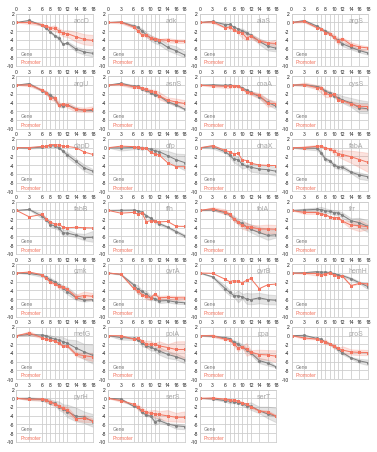

In [88]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (160/25.4, 200/25.4))
tight = 0

dict_results = {}

dict_convert_TPtoDoubling['t0'] = 'd0'
color_palette = ['gray', '#F37560']
i = 0
for gene in df_GenePromotersgRNAs_first_BothPres_SingleGene[(df_GenePromotersgRNAs_first_BothPres_SingleGene['Monocistronic?'] == 'Y')
                                               & (df_GenePromotersgRNAs_first_BothPres_SingleGene['#Promoter(s)'] == 1)].index:

    list_gene_sgRNAs = df_GenePromotersgRNAs_first_BothPres.loc[gene]['Gene sgRNAs']
    list_promoter_sgRNAs = df_GenePromotersgRNAs_first_BothPres.loc[gene]['Promoter sgRNAs']
    list_gene_sgRNAs_filt = [sg for sg in list_gene_sgRNAs if sg in df_sgRNA_counts_LR_withcounts_info_KDCols_filt.index]
    list_promoter_sgRNAs_filt = [sg for sg in list_promoter_sgRNAs if sg in df_sgRNA_counts_LR_withcounts_info_KDCols_filt.index]
    
    if (len(list_gene_sgRNAs_filt) > 0) and (len(list_promoter_sgRNAs_filt) > 0):
        
        df_working_AvgLR_gene = df_working_AvgLR.loc[list_gene_sgRNAs_filt].copy()
        df_working_AvgLR_gene = df_working_AvgLR_gene[df_working_AvgLR_gene['t15_Avg_LR'] <= -1]
        df_working_AvgLR_gene['seq'] = df_working_AvgLR_gene.index

        df_working_AvgLR_promoter = df_working_AvgLR.loc[list_promoter_sgRNAs_filt].copy()
        df_working_AvgLR_promoter = df_working_AvgLR_promoter[df_working_AvgLR_promoter['t15_Avg_LR'] <= -1]
        df_working_AvgLR_promoter['seq'] = df_working_AvgLR_promoter.index
        
        if (len(df_working_AvgLR_gene) > 0) and (len(df_working_AvgLR_promoter) > 0):
            i += 1
            ax = fig.add_subplot(7,4,i)
            
            df_working_AvgLR_gene_melt = pd.melt(df_working_AvgLR_gene, id_vars = 'seq', value_vars = [c for c in df_working_AvgLR_gene.columns if 'LR' in c])
            df_working_AvgLR_gene_melt['timepoint'] = df_working_AvgLR_gene_melt['variable'].apply(lambda x: x.split('_')[0])
            df_working_AvgLR_gene_melt['doubling'] = df_working_AvgLR_gene_melt['timepoint'].apply(lambda tp: int(dict_convert_TPtoDoubling[tp][1:]))
            df_working_AvgLR_gene_melt['category'] = 'gene'

            df_working_AvgLR_promoter_melt = pd.melt(df_working_AvgLR_promoter, id_vars = 'seq', value_vars = [c for c in df_working_AvgLR_gene.columns if 'LR' in c])
            df_working_AvgLR_promoter_melt['timepoint'] = df_working_AvgLR_promoter_melt['variable'].apply(lambda x: x.split('_')[0])
            df_working_AvgLR_promoter_melt['doubling'] = df_working_AvgLR_promoter_melt['timepoint'].apply(lambda tp: int(dict_convert_TPtoDoubling[tp][1:]))
            df_working_AvgLR_promoter_melt['category'] = 'promoter'
            
            dict_results[gene] = pd.concat([df_working_AvgLR_gene_melt, df_working_AvgLR_promoter_melt], axis=0)
            dict_results[gene]['gene'] = gene

            sns.lineplot(x = 'doubling', y = 'value', data = pd.concat([df_working_AvgLR_gene_melt, df_working_AvgLR_promoter_melt], axis = 0),
                      markers = ['o','s'], dashes = False, ci = 95, hue = 'category', style = 'category', palette = color_palette, legend = False,
                         **{'markersize': 3, 'mew': 0}, linewidth=1)
    
            ax.text(13.5,0,gene, fontsize = 7, color = 'darkgray')
            ax.text(1,-7.5,'Gene', color = color_palette[0], fontsize = 5)
            ax.text(1,-9.5,'Promoter', color = color_palette[1], fontsize = 5)
            
            ax.xaxis.tick_top()
            plt.xticks([0,3,6,7,8,9,10,11,12,14,16,18], [0,3,6,'',8,'',10,'',12,14,16,18])
            ax.set_xlabel('', fontsize = 5)    
            ax.xaxis.set_label_position('top')
            plt.yticks([-10,-8,-6,-4,-2,0,2], [-10,-8,-6,-4,-2,0,2])
            plt.tick_params(length = 0, labelsize = 5, pad = 2)
            plt.ylabel('', fontsize = 5)

            plt.xlim([0,18])
            plt.ylim([-10,2])
            
plt.savefig('Section 4v6/SuppFig_PromoterVsFirstGene_Monocistron_Monopromoter_EffectiveGuiesOnly_95CI_AltColor.pdf')
#plt.savefig('Section 4v6/SuppFig_PromoterVsFirstGene_Monocistron_Monopromoter_EffectiveGuiesOnly_95CI_AltColor.eps', type = 'eps')

## Data Export

In [92]:
df_SuppFig12 = pd.concat(dict_results.values())
df_SuppFig12 = df_SuppFig12.rename(columns={'value':'Fitness Score, Mean', 'doubling':'Population Doubling'})
df_SuppFig12 = df_SuppFig12[['seq', 'category', 'gene', 'Population Doubling', 'Fitness Score, Mean']]
df_SuppFig12.to_excel('Section 4v6/Table_SuppFig-12.xlsx')
df_SuppFig12

,seq,category,gene,Population Doubling,"Fitness Score, Mean"
0,cacttagtccacaccccttc,gene,accD,0,0.000000
1,cttcaggaatgctcgccttg,gene,accD,0,0.000000
2,ttcaggaatgctcgccttgc,gene,accD,0,0.000000
3,aggaatgctcgccttgcggg,gene,accD,0,0.000000
4,cacttagtccacaccccttc,gene,accD,3,0.563664
...,...,...,...,...,...
55,ttcaggcaaacaaacaaatt,promoter,serT,18,-4.420424
56,gtttatagtgcgcgtcattc,promoter,serT,18,-4.362570
57,gcactataaacatcccgatg,promoter,serT,18,-4.063010
58,taggggtttacacgccgcat,promoter,serT,18,-3.628983
